#  <p style="text-align: center;"><span style="background-color: #FFFF00"><u> Data Visualization and Analysis </u></span></p>

In [29]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import cv2
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

BGT=120
MaxBG = 180
MinBG = 70
RiskUpLimit = 50
RiskLowLimit = 0

file_name = "WT_labeled_data_patientA_80.csv"

## <p style="text-align: center;"><span style="background-color: #FFFF00"><u> Context Table </u></span></p>
<img src="context_table.png" width="700"/>

# <span style="background-color: #FFFF00"><u> Load the simulated data </u></span>

In [30]:
loaded_data = pd.read_csv(file_name, error_bad_lines=False)
#filtered_loaded_data = loaded_data.filter(["bg", "CGM_glucose", "IOB", "rate", "running_temp"], axis=1)
data = loaded_data.filter(["bg", "CGM_glucose", "IOB", "rate", "running_temp", "unsafe_action_reason"], axis=1)

In [31]:
loaded_data.head();

In [32]:
data["eq_glucose"] = data["CGM_glucose"]-45*data["IOB"]
data["BGT"] = BGT
data["MaxBG"] = MaxBG
data["MinBG"] = MinBG

## <span style="background-color: #FFFF00"><u> Risk Index calculation using following formula </u></span>
<b>BGT</b> = 120 in this case. It is patient dependent and comes from physician.  <br />
<b>MaxBG</b> = 180, Maximum glucose level above which it is treated as hyperglycemia.Comes from literature.  <br />
<b>MinBG</b> = 70, Minimum glucose level under which it is treated as hypoglycemia. Comes from literature. <br />

<b>UnderDose_risk_index (OD_Index)</b> = (CGM_glucose - BGT)/(MaxBG - BGT)  <br />
<b>OverDose_risk_index (UD_Index)</b> = (BGT - CGM_glucose)/(BGT - MinBG)

In [33]:
data["OD_index"] = 0
data["UD_index"] = 0
data["OD_index"] = data["OD_index"].astype(float)
data["UD_index"] = data["UD_index"].astype(float)
for i in range(len(data)-1):
    #print(i)
    #print(filtered_loaded_data["CGM_glucose"][i])
    #print((float(filtered_loaded_data["CGM_glucose"][i+1])-float(BGT))/(float(MaxBG)-float(BGT)))
    data["UD_index"][i] = (data["CGM_glucose"][i+1]-BGT)/(MaxBG-BGT)
    data["OD_index"][i] = (BGT-data["CGM_glucose"][i+1])/(BGT-MinBG)
    
data["UD_index"][len(data)-1] = data["UD_index"][len(data)-2]
data["OD_index"][len(data)-1] = data["OD_index"][len(data)-2]

C:\Users\BAHMED\miniconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\BAHMED\miniconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\BAHMED\miniconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\BAHMED\miniconda\lib\site-package

In [34]:
data["rate"] = 100*data["rate"]
data["OD_index"] = 50*data["OD_index"]
data["UD_index"] = 50*data["UD_index"]
data["IOB"] = 100*data["IOB"]

## <span style="background-color: #FFFF00"><u> Risk Index Calculation with the formula used in "Simglucose" simulator </u></span>
<img src="risk_index_formula_simglucose.png" width = "450"/>

In [35]:
rl_bg = []
rh_bg = []
LBGI = []
HBGI = []

for i in data["CGM_glucose"]:
    f_bg = 1.509*(math.pow((math.log(i)), 1.084) - 5.381)
    r_bg = 10*math.pow(f_bg, 2)
    
    if f_bg < 0:
        rl_bg.append(r_bg)
    else:
        rl_bg.append(0)
    
    if f_bg > 0:
        rh_bg.append(r_bg)
    else:
        rh_bg.append(0)
    
    LBGI.append(sum(rl_bg)/len(rl_bg))
    HBGI.append(sum(rh_bg)/len(rh_bg))

data["LBGI"] = LBGI
data["HBGI"] = HBGI
data["BGI"] = [i+j for i,j in zip(HBGI, LBGI)]

In [36]:
data.head()

,bg,CGM_glucose,IOB,rate,running_temp,unsafe_action_reason,eq_glucose,BGT,MaxBG,MinBG,OD_index,UD_index,LBGI,HBGI,BGI
0,80.0,80.0,-10.0,0.0,0.0,Null,84.500,120,180,70,40.00000,-33.333333,4.015354,0.0,4.015354
1,80.0,80.0,-14.9,0.0,0.0,Null,86.705,120,180,70,40.00000,-33.333333,4.015354,0.0,4.015354
2,80.0,80.0,-19.8,0.0,0.0,Null,88.910,120,180,70,40.00000,-33.333333,4.015354,0.0,4.015354
3,80.0,80.0,-24.6,0.0,0.0,Null,91.070,120,180,70,40.00000,-33.333333,4.015354,0.0,4.015354
4,80.0,80.0,-34.3,0.0,0.0,Null,95.435,120,180,70,39.99668,-33.330567,4.015354,0.0,4.015354


## Scale LBGI and HBGI to plot

In [37]:
data["LBGI"] = 5*data["LBGI"]
data["HBGI"] = 5*data["HBGI"]
data["BGI"] = 10*data["BGI"]

In [38]:
data.head(30)

,bg,CGM_glucose,IOB,rate,running_temp,unsafe_action_reason,eq_glucose,BGT,MaxBG,MinBG,OD_index,UD_index,LBGI,HBGI,BGI
0,80.00,80.000000,-10.0,0.0,0.00,Null,84.500000,120,180,70,40.000000,-33.333333,20.076768,0.0,40.153536
1,80.00,80.000000,-14.9,0.0,0.00,Null,86.705000,120,180,70,40.000000,-33.333333,20.076768,0.0,40.153536
2,80.00,80.000000,-19.8,0.0,0.00,Null,88.910000,120,180,70,40.000000,-33.333333,20.076768,0.0,40.153536
3,80.00,80.000000,-24.6,0.0,0.00,Null,91.070000,120,180,70,40.000000,-33.333333,20.076768,0.0,40.153536
4,80.00,80.000000,-34.3,0.0,0.00,Null,95.435000,120,180,70,39.996680,-33.330567,20.076768,0.0,40.153536
5,80.00,80.003320,-38.8,0.0,0.00,Null,97.463320,120,180,70,39.984545,-33.320454,20.075957,0.0,40.151913
6,80.02,80.015455,0.0,0.0,0.00,Null,80.015455,120,180,70,39.956812,-33.297343,20.072835,0.0,40.145670
7,80.04,80.043188,0.0,0.0,0.00,Null,80.043188,120,180,70,39.906095,-33.255079,20.065416,0.0,40.130832
8,80.09,80.093905,0.0,0.0,0.00,Null,80.093905,120,180,70,39.824903,-33.187420,20.051407,0.0,40.102815
9,80.18,80.175097,0.0,0.0,0.00,Null,80.175097,120,180,70,39.706005,-33.088337,20.028369,0.0,40.056737


## <span style="background-color: #FFFF00"><u> Slope Calculation </u></span>

In [39]:
#data["Slope"] = 0
#data["Slope"] = data["Slope"].astype(float)
#for i in range(len(data)-2):
#    data["Slope"][i] = (data["BGI"][i+1]-data["BGI"][i])/5
#data["Slope"][len(data)-2] = data["Slope"][len(data)-3]
#data["Slope"][len(data)-1] = data["Slope"][len(data)-2]
#data["Slope"] = 1000*data["Slope"]

In [40]:
#data.head(20)

## <span style="background-color: #FFFF00"><u> Data Labeling </u></span>

In [41]:
#data["Label"] = 0
#data["Label"] = data["OD_index"].astype(float)
#for i in range(len(data)-1):
#    if (data["BGI"][i+1]-data["BGI"][i]) >=.5:
#        data["Label"][i] = 100
#    else:
#        data["Label"][i] = 0
#data["Label"][len(data)-1] = data["Label"][len(data)-2]

data["Label"] = 0
data["Label"] = data["Label"].astype(float)
for i in range(len(data)-2):
    if (data["BGI"][i+2]-data["BGI"][i] >=.45):
        data["Label"][i] = 100
    else:
        data["Label"][i] = 0
data["Label"][len(data)-2] = data["Label"][len(data)-3]
data["Label"][len(data)-1] = data["Label"][len(data)-2]

C:\Users\BAHMED\miniconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\BAHMED\miniconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\BAHMED\miniconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
data.head()

,bg,CGM_glucose,IOB,rate,running_temp,unsafe_action_reason,eq_glucose,BGT,MaxBG,MinBG,OD_index,UD_index,LBGI,HBGI,BGI,Label
0,80.0,80.0,-10.0,0.0,0.0,Null,84.500,120,180,70,40.00000,-33.333333,20.076768,0.0,40.153536,0.0
1,80.0,80.0,-14.9,0.0,0.0,Null,86.705,120,180,70,40.00000,-33.333333,20.076768,0.0,40.153536,0.0
2,80.0,80.0,-19.8,0.0,0.0,Null,88.910,120,180,70,40.00000,-33.333333,20.076768,0.0,40.153536,0.0
3,80.0,80.0,-24.6,0.0,0.0,Null,91.070,120,180,70,40.00000,-33.333333,20.076768,0.0,40.153536,0.0
4,80.0,80.0,-34.3,0.0,0.0,Null,95.435,120,180,70,39.99668,-33.330567,20.076768,0.0,40.153536,0.0


In [43]:
#label = [0]
#for i in range(len(data["BGI"])-1):
#    if ((data["BGI"][i+1]-data["BGI"][i])>=1):
#        label.append(100)
#    else:
#        label.append(0)
#data["Label"] = label

In [44]:
data.head()

,bg,CGM_glucose,IOB,rate,running_temp,unsafe_action_reason,eq_glucose,BGT,MaxBG,MinBG,OD_index,UD_index,LBGI,HBGI,BGI,Label
0,80.0,80.0,-10.0,0.0,0.0,Null,84.500,120,180,70,40.00000,-33.333333,20.076768,0.0,40.153536,0.0
1,80.0,80.0,-14.9,0.0,0.0,Null,86.705,120,180,70,40.00000,-33.333333,20.076768,0.0,40.153536,0.0
2,80.0,80.0,-19.8,0.0,0.0,Null,88.910,120,180,70,40.00000,-33.333333,20.076768,0.0,40.153536,0.0
3,80.0,80.0,-24.6,0.0,0.0,Null,91.070,120,180,70,40.00000,-33.333333,20.076768,0.0,40.153536,0.0
4,80.0,80.0,-34.3,0.0,0.0,Null,95.435,120,180,70,39.99668,-33.330567,20.076768,0.0,40.153536,0.0


In [45]:
data["Label"].sum()

0.0

## <span style="background-color: #FFFF00"><u> Save labeled data to csv file </u></span>

In [46]:
#data.to_csv("labeled_"+file_name)

In [47]:
num_label = 0
data_rows_of_positive_label = []
for i in range(len(data.index)):
    if data["Label"][i] != 0:
        num_label +=1
        data_rows_of_positive_label.append(i)
#data.loc[data_rows_of_positive_label]

In [48]:
risk_up_limit = [RiskUpLimit]*len(data.index)
risk_low_limit = [RiskLowLimit]*len(data.index)

## <span style="background-color: #FFFF00"><u> Rows having Unsafe action reason </u></span>

In [49]:
violation = 0
data_rows_of_violation = []
for i in range(len(data.index)):
    if data["unsafe_action_reason"][i] != "Null":
        violation +=1
        data_rows_of_violation.append(i)
data.loc[data_rows_of_violation]

,bg,CGM_glucose,IOB,rate,running_temp,unsafe_action_reason,eq_glucose,BGT,MaxBG,MinBG,OD_index,UD_index,LBGI,HBGI,BGI,Label


In [50]:
print("The Number of rule violation: ",violation)

The Number of rule violation:  0


In [51]:
for index,row in data.iterrows():
    if data.at[index,"unsafe_action_reason"] == "Null":
        data.at[index,"unsafe_action_reason"] = 0
    else:
        data.at[index,"unsafe_action_reason"] = 300
#data.head()

In [52]:
data.head()

,bg,CGM_glucose,IOB,rate,running_temp,unsafe_action_reason,eq_glucose,BGT,MaxBG,MinBG,OD_index,UD_index,LBGI,HBGI,BGI,Label
0,80.0,80.0,-10.0,0.0,0.0,0,84.500,120,180,70,40.00000,-33.333333,20.076768,0.0,40.153536,0.0
1,80.0,80.0,-14.9,0.0,0.0,0,86.705,120,180,70,40.00000,-33.333333,20.076768,0.0,40.153536,0.0
2,80.0,80.0,-19.8,0.0,0.0,0,88.910,120,180,70,40.00000,-33.333333,20.076768,0.0,40.153536,0.0
3,80.0,80.0,-24.6,0.0,0.0,0,91.070,120,180,70,40.00000,-33.333333,20.076768,0.0,40.153536,0.0
4,80.0,80.0,-34.3,0.0,0.0,0,95.435,120,180,70,39.99668,-33.330567,20.076768,0.0,40.153536,0.0


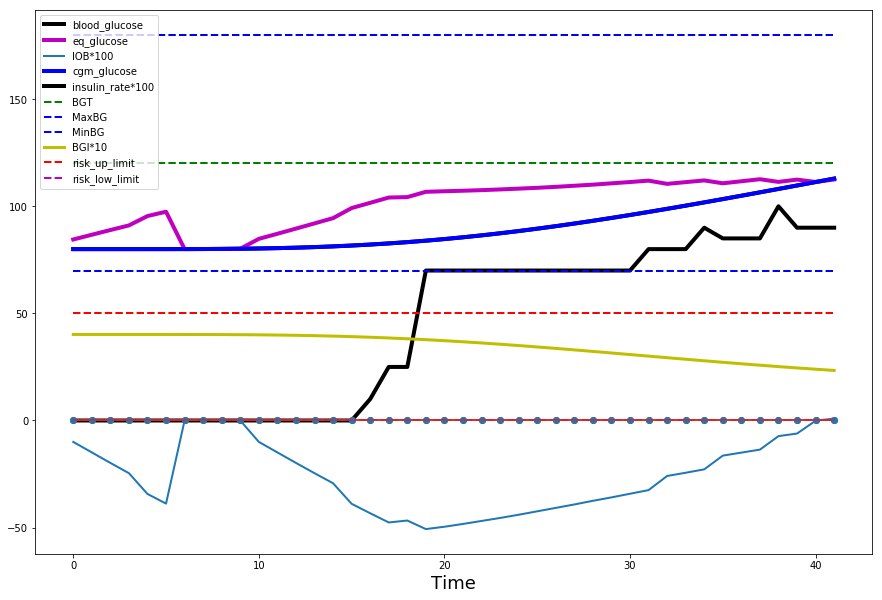

In [53]:
plt.figure(figsize=(15,10))
plt.plot(data.index, data["bg"], linewidth=4, label="blood_glucose", color='k')
plt.plot(data.index, data["eq_glucose"], linewidth=4, label="eq_glucose", color='m')
plt.plot(data.index, data["IOB"], linewidth=2, label="IOB*100")
plt.plot(data.index, data["CGM_glucose"], linewidth=4, label="cgm_glucose", color = 'b')
plt.plot(data.index, data["rate"], linewidth=4, label="insulin_rate*100", color='k')
#plt.plot(data.index, data["OD_index"], linewidth=2, label="OverDoase_risk_index*50", color='r')
#plt.plot(data.index, data["UD_index"], linewidth = 2, label="UnderDose_risk_index*50", color='y')
plt.plot(data.index, data["BGT"], linewidth = 2, label="BGT", linestyle="--", color = 'g')
plt.plot(data.index, data["MaxBG"], linewidth = 2, label="MaxBG", linestyle="--", color = 'b')
plt.plot(data.index, data["MinBG"], linewidth = 2, label="MinBG", linestyle="--", color = 'b')
#plt.plot(filtered_loaded_data.index, filtered_loaded_data["HBGI"], linewidth = 2, label="HBGI*5")
#plt.plot(filtered_loaded_data.index, filtered_loaded_data["LBGI"], linewidth = 2, label="LBGI*5")
plt.plot(data.index, data["BGI"], linewidth = 3, label="BGI*10", color = 'y')
plt.plot(data.index, risk_up_limit, linewidth = 2, label="risk_up_limit", linestyle="--", color = 'r')
plt.plot(data.index, risk_low_limit, linewidth = 2, label="risk_low_limit", linestyle="--", color = 'm')
#plt.stem(data.index, data["unsafe_action_reason"])
plt.stem(data.index, data["Label"], 'g')
plt.stem(data.index, loaded_data["detection"])
#plt.plot(data.index, data["Slope"], 'b')
plt.xlabel('Time', fontsize=18)
plt.legend()
plt.show()

In [54]:
print("Simulation time: ", len(data)*5, " minutes")
print("Number of unsafe control actions: ", violation)

Simulation time:  210  minutes
Number of unsafe control actions:  0


In [55]:
y_pred = np.array(loaded_data["detection"].tolist())
y_true = np.array(data["Label"].tolist())
#writeFile_F1 = open("f1_score.txt_"+str(file_name), "w+")
#writeFile_CM.write(np.array2string(confusion_matrix(y_true, y_pred)))
#writeFile_F1.write(classification_report(y_true, y_pred))
#f1Score = f1_score(y_true, y_pred,average=None)
f1Score = f1_score(y_true, y_pred,average='macro')

In [56]:
print("f1_score: ", f1Score)

f1_score:  1.0


In [58]:
loaded_data["Label"].sum()

0.0